## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import platform
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from tqdm import tqdm
from matplotlib import font_manager, rc
from scipy.stats import shapiro
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("../data/Original_data/train.csv")
test = pd.read_csv("../data/Original_data/test.csv")
xy = pd.read_csv("../data/Preprocessed_data/xy-V2.csv")

print(f"Train Data: {train.shape}")
print(f"Test Data: {test.shape}")
print(f"XY Data: {xy.shape}")

Train Data: (1118822, 52)
Test Data: (9272, 51)
XY Data: (8196, 5)


In [3]:
target = train['target']
train_df = train.drop(columns=['target']).copy()
train_df['original_index'] = train_df.index

test_df = test.copy()
test_df['original_index'] = test_df.index

train_df['label'] = 'Train' # train
test_df['label'] = 'Test' # tets

df = pd.concat([train_df, test_df], ignore_index=True)
print(f"df: {df.shape}")
df.head()

df: (1128094, 53)


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,original_index,label
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,0,Train
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,1,Train
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,2,Train
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,3,Train
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,4,Train


In [4]:
xy.head(3)

,구,동,번지,위도,경도
0,강남구,역삼동,762,37.495583,127.046917
1,강북구,수유동,282-20,37.646608,127.014052
2,구로구,구로동,107-4,37.498664,126.891127


## Data Preprocessing

- Data Mapping
- Missing value handling
- Outlier
- Scaling
- Encoding

In [5]:
# Data type check
def check_dtype(df, return_data=False):
    object_df = df.select_dtypes(include=['object'])
    num_df = df.select_dtypes(include=['number'])

    print(f"Object Data Type: {object_df.shape[1]}")
    print(f"Number Data Type: {num_df.shape[1]}")

    if return_data: # 데이터 프레임 할당
        return object_df, num_df
    
# Null check
def check_NaN(df):
    nan_value = df.isna().sum()
    nan_ratio = (nan_value / len(df)) * 100
    df_nan = pd.DataFrame({'Columns':df.columns, 'Missing_Values':nan_value, 'Missing_ratio%':nan_ratio})
    df_nan = df_nan[df_nan['Missing_Values'] > 0].sort_values(by=['Missing_ratio%'], ascending=False).reset_index(drop=True)
    print(f"Missing Value Columns: {len(df_nan)}")
    return df_nan

# normality check
def check_shapiro(df, sample_size=5000, return_data=False):
    shapiro_data = [] # 정규성 col
    shapiro_Not = [] # 비정규성 col
    shapiro_results = [] # 전체 결과
    df = df.select_dtypes(include=['number']).copy() # 수치형 검정
    
    for col in df.columns:
        values = df[col].dropna()
        values = values.sample(sample_size, random_state=42) # sample_size == 5,000
        stat, p_value = shapiro(values)

        if p_value > 0.05:
            shapiro_data.append(col)
        else:
            shapiro_Not.append(col)
        
        shapiro_results.append({
            "Columns": col,
            "Stat": round(stat, 4),
            "P-value": round(p_value, 4),
            "result": '정규성 만족' if p_value > 0.05 else '불만족'})
            
    print(f"정규성 만족 Columns: {len(shapiro_data)}")            
    print(f"정규성 불만족 Columns: {len(shapiro_Not)}") 

    if return_data:
        return pd.DataFrame(shapiro_results)

# mode check
def check_mode(df):
    df = df.select_dtypes(include=['object']).copy()
    result = []

    for col in df.columns:
        mode_val = df[col].mode()[0] # 최빈값
        mode_ratio = round((df[col] == mode_val).sum() / len(df) * 100, 4)
        unique_cnt = int(df[col].nunique())

        result.append({
            'Columns': col,
            'mode': mode_val,
            'ratio(%)': mode_ratio,
            'Unique_Count': unique_cnt})
    
    result_df = pd.DataFrame(result)
    result_df['Unique_Count'] = result_df['Unique_Count'].astype(int) 
    return result_df.sort_values(by=['Unique_Count'], ascending=False)

In [6]:
# font
path = '/library/Fonts/Arial Unicode.ttf'

if platform.system() == 'Darwin':
    print('Hangul OK in your MAC!')
    rc('font', family='Arial Unicode MS')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.. sorry')
plt.rcParams['axes.unicode_minus'] = False

# Count_plot
def count_plot(df, col, figsize=(10, 6), palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel='Count'):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=col, palette=palette)
    plt.title(title if title else f'{col} Count')
    plt.xticks(rotation=rotation)
    plt.xlabel(xlabel if xlabel is not None else col)
    plt.ylabel(ylabel)
    plt.show()

# bar_plot    
def bar_plot(df, x_col, y_col, figsize=(10, 6), hue=None, palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel=None):
     plt.figure(figsize=figsize)
     
     if hue: # hue 지정
        sns.barplot(x=x_col, y=y_col, hue=hue, data=df, palette=palette)
     else: # hue 지정 X
        sns.barplot(x=x_col, y=y_col, data=df, palette=palette)

     plt.xticks(rotation=rotation)
     plt.title(title)
     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.show()

# box_plot
def box_plot(df1, col, df2=None, figsize=(8, 6), color1='skyblue', color2='salmon', title=None):
    plt.figure(figsize=figsize)

    if df2 is None:
        # 단일 데이터프레임 boxplot
        sns.boxplot(y=df1[col], color=color1)  # 개별일 때는 color1 (기본값 skyblue)
        plt.ylabel(col)
        plt.title(title if title else f'{col} (Box Plot)')
    else:
        # 두 데이터프레임 비교 boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(y=df1[col], color=color1)  # 첫 번째 그룹은 color1
        plt.ylabel(col)
        plt.title(f'Group 1 - {col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=df2[col], color=color2)  # 두 번째 그룹은 color2
        plt.ylabel(col)
        plt.title(f'Group 2 - {col}')

        plt.suptitle(title if title else f'{col} Comparison (Box Plot)', fontsize=12)

    plt.show()

# hist_plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, color1='skyblue', color2='salmon', label1=None, label2=None, title=None):
    plt.figure(figsize=figsize)

    # 개별 데이터 프레임
    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, label=label1 if label1 else ('Group 1' if df2 is not None else None))
    
    if df2 is not None: # 두 그룹 비교
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, label=label2 if label2 else 'Group 2')
        plt.legend()  # 두 그룹일 때만 범례 표시

    plt.title(title if title else f'{col} Distribution (Histogram + KDE)')
    plt.xlabel(col)
    plt.show()

# heat_map
def heat_map(df, target_col=None, figsize=(8, 10), threshold=0, cmap='Reds', method='pearson', annot_kws=None, return_data=False):
        df = df.select_dtypes(include=['number'])
        
        if annot_kws is None:
            annot_kws = {"size": 10}

        if target_col is not None:
            corr_series = df.corr(method=method)[target_col].drop(target_col)
            corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

            plt.figure(figsize=figsize)
            sns.heatmap(corr_filtered.to_frame(name='Correlation'), annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation with {target_col}', fontsize=14)
            plt.show()

            corr_df = corr_filtered.reset_index()
            corr_df.columns = ['Variable', 'Correlation']

            if return_data:
                return corr_df

        else:
            corr_matrix = df.corr(method=method) # 전체 변수 간 상관계수

            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation Matrix (All Variables)', fontsize=14)
            plt.show()

            if return_data:
                return corr_matrix

Hangul OK in your MAC!


In [7]:
df['구'] = df['시군구'].str.split().str[1]
df['동'] = df['시군구'].str.split().str[2]
df.drop(columns=['시군구'], inplace=True)
cols = ['구', '동'] + [col for col in df.columns if col not in ['구', '동']]
df = df[cols]
print(f"{df[['구', '동']].isna().sum()}")
df.head()

구    0
동    0
dtype: int64


,구,동,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,original_index,label
0,강남구,개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,0,Train
1,강남구,개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,1,Train
2,강남구,개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,2,Train
3,강남구,개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,3,Train
4,강남구,개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,4,Train


In [8]:
# 제거할 컬럼
drop_col = ['k-전화번호', 'k-팩스번호', '단지소개기존clob', '본번', '부번',
           'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호']

df[drop_col] # 확인

,k-전화번호,k-팩스번호,단지소개기존clob,본번,부번,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호
0,025776611,025776673,NaN,658.0,1.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN
1,025776611,025776673,NaN,658.0,1.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN
2,025776611,025776673,NaN,658.0,1.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN
3,025776611,025776673,NaN,658.0,1.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN
4,025776611,025776673,NaN,658.0,1.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN
...,...,...,...,...,...,...,...,...,...
1128089,024969683,024969685,4.0,816.0,0.0,NaN,NaN,2023-09-23 09:00:52.0,2048279333
1128090,024969683,024969685,4.0,816.0,0.0,NaN,NaN,2023-09-23 09:00:52.0,2048279333
1128091,024969683,024969685,4.0,816.0,0.0,NaN,NaN,2023-09-23 09:00:52.0,2048279333
1128092,024969683,024969685,4.0,816.0,0.0,NaN,NaN,2023-09-23 09:00:52.0,2048279333


In [9]:
# 제거 고려 컬럼
exclude_cols = ['해제사유발생일', '등기신청일자', 'k-사용검사일-사용승인일', '단지승인일', '단지신청일']
df[exclude_cols]

,해제사유발생일,등기신청일자,k-사용검사일-사용승인일,단지승인일,단지신청일
0,NaN,,1987-11-21 00:00:00.0,2022-11-17 13:00:29.0,2022-11-17 10:19:06.0
1,NaN,,1987-11-21 00:00:00.0,2022-11-17 13:00:29.0,2022-11-17 10:19:06.0
2,NaN,,1987-11-21 00:00:00.0,2022-11-17 13:00:29.0,2022-11-17 10:19:06.0
3,NaN,,1987-11-21 00:00:00.0,2022-11-17 13:00:29.0,2022-11-17 10:19:06.0
4,NaN,,1987-11-21 00:00:00.0,2022-11-17 13:00:29.0,2022-11-17 10:19:06.0
...,...,...,...,...,...
1128089,20230801.0,,2014-06-18 00:00:00.0,2015-09-09 15:30:27.0,2014-09-01 13:05:03.0
1128090,NaN,,2014-06-18 00:00:00.0,2015-09-09 15:30:27.0,2014-09-01 13:05:03.0
1128091,NaN,,2014-06-18 00:00:00.0,2015-09-09 15:30:27.0,2014-09-01 13:05:03.0
1128092,NaN,,2014-06-18 00:00:00.0,2015-09-09 15:30:27.0,2014-09-01 13:05:03.0


In [10]:
drop_cols = exclude_cols + drop_col
df = df.drop(columns=drop_cols) # 제거
df.rename(columns={'좌표X':'경도', '좌표Y':'위도'}, inplace=True) # 이름 변경
df

,구,동,번지,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,사용허가여부,관리비 업로드,경도,위도,original_index,label
0,강남구,개포동,658-1,개포6차우성,79.97,201712,8,3,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,0,Train
1,강남구,개포동,658-1,개포6차우성,79.97,201712,22,4,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,1,Train
2,강남구,개포동,658-1,개포6차우성,54.98,201712,28,5,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,2,Train
3,강남구,개포동,658-1,개포6차우성,79.97,201801,3,4,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,3,Train
4,강남구,개포동,658-1,개포6차우성,79.97,201801,8,2,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,4,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,중랑구,신내동,816,신내우디안1단지,84.65,202307,19,13,2014,신내역로1길 85,...,위탁,14171.0,1568.0,의무,Y,N,127.10672,37.618870,9267,Test
1128090,중랑구,신내동,816,신내우디안1단지,84.62,202307,25,12,2014,신내역로1길 85,...,위탁,14171.0,1568.0,의무,Y,N,127.10672,37.618870,9268,Test
1128091,중랑구,신내동,816,신내우디안1단지,101.65,202308,27,12,2014,신내역로1길 85,...,위탁,14171.0,1568.0,의무,Y,N,127.10672,37.618870,9269,Test
1128092,중랑구,신내동,816,신내우디안1단지,84.94,202309,2,18,2014,신내역로1길 85,...,위탁,14171.0,1568.0,의무,Y,N,127.10672,37.618870,9270,Test


### Missing value handling

In [11]:
# 분리
train_df = df[df['label'] == 'Train'].copy().sort_values('original_index').reset_index(drop=True)
test_df = df[df['label'] == 'Test'].copy().sort_values('original_index').reset_index(drop=True)
train_df['target'] = target.reset_index(drop=True)

is_train_index = train.index.equals(train_df.index)
is_test_index = test.index.equals(test_df.index)

print(f"Train Data: {train_df.shape}")
print(f"Test Data: {test_df.shape}\n")

print(f"Train Data Missing Value: {train_df.isna().sum().sum()}")
print(f"Test Data Missing Value: {test_df.isna().sum().sum()}\n")

print(f"Train 인덱스 동일 여부: {is_train_index}")
print(f"Test 인덱스 동일 여부: {is_test_index}")

Train Data: (1118822, 41)
Test Data: (9272, 40)

Train Data Missing Value: 22878549
Test Data Missing Value: 173510

Train 인덱스 동일 여부: True
Test 인덱스 동일 여부: True


- Train Data

Object Data Type: 21
Number Data Type: 20
Missing Value Columns: 28


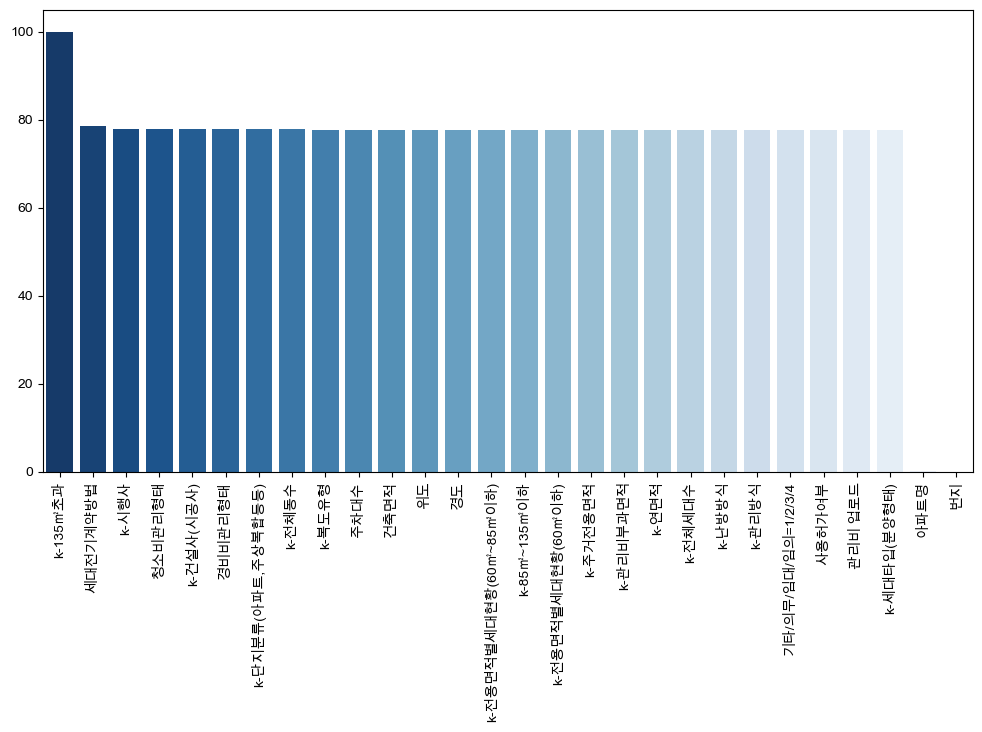

,Columns,Missing_Values,Missing_ratio%,mode,ratio(%),Unique_Count,dtype
0,k-135㎡초과,1118495,99.970773,NaN,NaN,NaN,float64
1,세대전기계약방법,878747,78.542163,종합계약,10.9913,2.0,object
2,k-시행사,871254,77.872441,SH공사,1.1168,555.0,object
3,청소비관리형태,871178,77.865648,위탁,20.1119,4.0,object
4,k-건설사(시공사),871058,77.854922,삼성물산,1.2586,344.0,object
5,경비비관리형태,870988,77.848666,위탁,18.4481,4.0,object
6,"k-단지분류(아파트,주상복합등등)",870691,77.822120,아파트,21.0931,5.0,object
7,k-전체동수,870630,77.816668,NaN,NaN,NaN,float64
8,k-복도유형,869890,77.750527,계단식,11.0519,5.0,object
9,주차대수,869714,77.734796,NaN,NaN,NaN,float64


In [12]:
# Train Data Missing Value
str_df, num_df = check_dtype(train_df, return_data=True)
nan_data = check_NaN(train_df) 
nan_cols = nan_data['Columns'].tolist() # 결측치 list
nan_mode = check_mode(train_df[nan_cols]) # 최빈값 확인
nan_df = pd.merge(nan_data, nan_mode, on='Columns', how='left')
nan_df['dtype'] = nan_df['Columns'].map(train_df.dtypes)

bar_plot(df=nan_df, x_col='Columns', y_col='Missing_ratio%', figsize=(12, 6), rotation=90) # 시각화
nan_df

- Test Data

In [13]:
# Test Data Missing Value
str_test, num_test = check_dtype(test_df, return_data=True)
nan_test = check_NaN(test_df) 
test_nan_cols = nan_test['Columns'].tolist() # 결측치 list
test_nan_mode = check_mode(test_df[nan_cols]) # 최빈값 확인
test_nan_df = pd.merge(nan_test, test_nan_mode, on='Columns', how='left')
test_nan_df['dtype'] = test_nan_df['Columns'].map(test_df.dtypes)

test_nan_df

Object Data Type: 21
Number Data Type: 19
Missing Value Columns: 28


,Columns,Missing_Values,Missing_ratio%,mode,ratio(%),Unique_Count,dtype
0,k-135㎡초과,9270,99.978430,NaN,NaN,NaN,float64
1,세대전기계약방법,6642,71.635030,종합계약,17.6553,2.0,object
2,"k-단지분류(아파트,주상복합등등)",6582,70.987921,아파트,27.9551,4.0,object
3,k-시행사,6580,70.966350,SH공사,1.1756,440.0,object
4,k-건설사(시공사),6579,70.955565,삼성물산,1.9198,268.0,object
5,k-전체동수,6577,70.933995,NaN,NaN,NaN,float64
6,청소비관리형태,6573,70.890854,위탁,26.9090,4.0,object
7,경비비관리형태,6573,70.890854,위탁,25.4098,4.0,object
8,건축면적,6565,70.804573,NaN,NaN,NaN,float64
9,k-복도유형,6564,70.793788,계단식,14.1609,5.0,object


- Total Data

In [14]:
xy_key = xy[['구', '동', '번지', '위도', '경도']].drop_duplicates(subset=['구', '동', '번지'])
na_mask = df['위도'].isna() | df['경도'].isna()
na_rows = df.loc[na_mask, ['구', '동', '번지']].copy()

na_merged = na_rows.merge(xy_key, on=['구', '동', '번지'], how='left')
df.loc[na_mask, ['위도', '경도']] = na_merged[['위도', '경도']].values
df[df[['위도', '경도']].isna().any(axis=1)][['구', '동', '번지', '아파트명', '위도', '경도']] # 확인

,구,동,번지,아파트명,위도,경도
50094,동작구,신대방동,729-24,캐릭터그린빌,NaN,NaN
50397,마포구,공덕동,800,공덕자이,NaN,NaN
60194,서초구,신원동,NaN,힐스테이트 서초 젠트리스,NaN,NaN
60195,서초구,신원동,NaN,힐스테이트 서초 젠트리스,NaN,NaN
60196,서초구,신원동,NaN,힐스테이트 서초 젠트리스,NaN,NaN
...,...,...,...,...,...,...
1107102,성동구,하왕십리동,845,한진해모로,NaN,NaN
1107103,성동구,하왕십리동,845,한진해모로,NaN,NaN
1107104,성동구,하왕십리동,845,한진해모로,NaN,NaN
1107105,성동구,하왕십리동,845,한진해모로,NaN,NaN


In [15]:
# 중복 제거 후 확인
df[df[['위도', '경도']].isna().any(axis=1)][['구', '동', '번지', '아파트명', '위도', '경도']].drop_duplicates()

,구,동,번지,아파트명,위도,경도
50094,동작구,신대방동,729-24,캐릭터그린빌,NaN,NaN
50397,마포구,공덕동,800,공덕자이,NaN,NaN
60194,서초구,신원동,NaN,힐스테이트 서초 젠트리스,NaN,NaN
61634,성동구,금호동2가,1331,두산,NaN,NaN
62188,성동구,상왕십리동,1070,센트라스,NaN,NaN
66842,성북구,동소문동7가,280,한신플러스A,NaN,NaN
66843,성북구,동소문동7가,261,한신플러스B,NaN,NaN
70416,성북구,하월곡동,949,상그레빌,NaN,NaN
89119,은평구,수색동,223-28,DMC자이2단지,NaN,NaN
91652,종로구,교남동,199,경희궁자이,NaN,NaN


In [16]:
# 수집한 위도/경도 
manual_lat_lon = pd.DataFrame({
    '구': [
        '동작구', '마포구', '서초구', '성동구', '성동구', '성북구', '성북구', '성북구',
        '은평구', '종로구', '종로구', '구로구', '성동구', '동작구', '마포구', '서초구',
        '서초구', '양천구', '용산구', '용산구', '서대문구', '성동구', '강남구'
    ],
    '동': [
        '신대방동', '공덕동', '신원동', '금호동2가', '상왕십리동', '동소문동7가', '동소문동7가', '하월곡동',
        '수색동', '교남동', '교남동', '천왕동', '하왕십리동', '상도동', '노고산동', '내곡동',
        '내곡동', '목동', '문배동', '효창동', '남가좌동', '하왕십리동', '율현동'
    ],
    '번지': [
        '729-24', '800', 'NaN', '1331', '1070', '280', '261', '949',
        '223-28', '199', '233', '292-10', '845', '1000', '807', '568',
        '619', '1078', '133-3', '11-168', '458', '811', '686'
    ],
    '아파트명': [
        '캐릭터그린빌', '공덕자이', '힐스테이트 서초 젠트리스', '두산', '센트라스',
        '한신플러스A', '한신플러스B', '상그레빌', 'DMC자이2단지', '경희궁자이', '경희궁자이',
        '우정굿모닝', '한진해모로', '현대', '신촌그랑자이', '서초포레스타3단지', '서초포레스타6단지',
        '목동센트럴아이파크위브4단지', '리첸시아용산', '효창그린빌라트', 'DMC아이파크', '텐즈힐', '강남한양수자인'
    ],
    '위도': [
        37.4917374, 37.5530229, 37.4561278, 37.5500865, 37.562604,
        37.5963265, 37.5963117, 37.6119888, 37.5786058, 37.5704927,
        37.5714017, 37.4866808, 37.563077, 37.4940989, 37.5553725,
        37.4549284, 37.450034, 37.5174709, 37.5380381, 37.5420653,
        37.5785846, 37.4758377, 37.4678389
    ],
    '경도': [
        126.9251157, 126.9585419, 127.057312, 127.0159533, 127.0366332,
        127.0141985, 127.013792, 127.0379303, 126.8994532, 126.963397,
        126.9615269, 126.8299585, 127.0264702, 126.9593345, 126.9444823,
        127.0591406, 127.05567, 126.8444157, 126.9675825, 126.9631383,
        126.9207143, 127.1126859, 127.1118082
    ]
})

manual_lat_lon

,구,동,번지,아파트명,위도,경도
0,동작구,신대방동,729-24,캐릭터그린빌,37.491737,126.925116
1,마포구,공덕동,800,공덕자이,37.553023,126.958542
2,서초구,신원동,NaN,힐스테이트 서초 젠트리스,37.456128,127.057312
3,성동구,금호동2가,1331,두산,37.550086,127.015953
4,성동구,상왕십리동,1070,센트라스,37.562604,127.036633
5,성북구,동소문동7가,280,한신플러스A,37.596327,127.014199
6,성북구,동소문동7가,261,한신플러스B,37.596312,127.013792
7,성북구,하월곡동,949,상그레빌,37.611989,127.037930
8,은평구,수색동,223-28,DMC자이2단지,37.578606,126.899453
9,종로구,교남동,199,경희궁자이,37.570493,126.963397


In [17]:
for i, row in manual_lat_lon.iterrows():
    condition = (
        (df['구'] == row['구']) &
        (df['동'] == row['동']) &
        (df['번지'] == row['번지']) &
        (df['아파트명'] == row['아파트명']) &
        (df['위도'].isna() | df['경도'].isna()))
    
    df.loc[condition, '위도'] = row['위도']
    df.loc[condition, '경도'] = row['경도']

print("남은 위도 결측치:", df['위도'].isna().sum())
print("남은 경도 결측치:", df['경도'].isna().sum())

df[df[['위도', '경도']].isna().any(axis=1)][['구', '동', '번지', '아파트명', '위도', '경도']].drop_duplicates() # 확인

남은 위도 결측치: 111
남은 경도 결측치: 111


,구,동,번지,아파트명,위도,경도
60194,서초구,신원동,NaN,힐스테이트 서초 젠트리스,NaN,NaN
108725,구로구,천왕동,292-10,우창굿모닝,NaN,NaN


In [18]:
# 힐스테이트 서초 젠트리스 (번지 == np.nan 처리)
df.loc[
    (df['구'] == '서초구') &
    (df['동'] == '신원동') &
    (df['번지'].isna()) &
    (df['아파트명'] == '힐스테이트 서초 젠트리스'),
    ['위도', '경도']
] = [37.4561278, 127.057312]

# 우창굿모닝 (정상적인 번지 매핑)
df.loc[
    (df['구'] == '구로구') &
    (df['동'] == '천왕동') &
    (df['번지'] == '292-10') &
    (df['아파트명'] == '우창굿모닝'),
    ['위도', '경도']
] = [37.4866808, 126.8299585]

print("남은 위도 결측치:", df['위도'].isna().sum())
print("남은 경도 결측치:", df['경도'].isna().sum())

df[df[['위도', '경도']].isna().any(axis=1)][['구', '동', '번지', '아파트명', '위도', '경도']].drop_duplicates() # 확인

남은 위도 결측치: 0
남은 경도 결측치: 0


,구,동,번지,아파트명,위도,경도


In [19]:
# 재분리
train_df = df[df['label'] == 'Train'].copy().sort_values('original_index').reset_index(drop=True)
test_df = df[df['label'] == 'Test'].copy().sort_values('original_index').reset_index(drop=True)
train_df['target'] = target.reset_index(drop=True)

is_train_index = train.index.equals(train_df.index)
is_test_index = test.index.equals(test_df.index)

print(f"Train Data: {train_df.shape}")
print(f"Test Data: {test_df.shape}\n")

print(f"Train Data Missing Value: {train_df.isna().sum().sum()}")
print(f"Test Data Missing Value: {test_df.isna().sum().sum()}\n")

print(f"Train 인덱스 동일 여부: {is_train_index}")
print(f"Test 인덱스 동일 여부: {is_test_index}")

Train Data: (1118822, 41)
Test Data: (9272, 40)

Train Data Missing Value: 21139209
Test Data Missing Value: 160386

Train 인덱스 동일 여부: True
Test 인덱스 동일 여부: True


In [20]:
# Train Data type 분리
str_df, num_df = check_dtype(train_df, return_data=True)
nan_data = check_NaN(train_df) 
nan_cols = nan_data['Columns'].tolist() # 결측치 list
nan_mode = check_mode(train_df[nan_cols]) # 최빈값 확인
nan_df = pd.merge(nan_data, nan_mode, on='Columns', how='left')
nan_df['dtype'] = nan_df['Columns'].map(train_df.dtypes)

str_nan = nan_df[nan_df['dtype'] == 'object'].sort_values(by=['Missing_ratio%'], ascending=False).reset_index(drop=True)
num_nan = nan_df[nan_df['dtype'] == 'float64'].sort_values(by=['Missing_ratio%'], ascending=False).reset_index(drop=True)

print(f"Missing Object Type: {len(str_nan)}")
print(f"Missing Number Type: {len(num_nan)}")

Object Data Type: 21
Number Data Type: 20
Missing Value Columns: 26
Missing Object Type: 15
Missing Number Type: 11


- 범주형 결측치

In [21]:
str_nan

,Columns,Missing_Values,Missing_ratio%,mode,ratio(%),Unique_Count,dtype
0,세대전기계약방법,878747,78.542163,종합계약,10.9913,2.0,object
1,k-시행사,871254,77.872441,SH공사,1.1168,555.0,object
2,청소비관리형태,871178,77.865648,위탁,20.1119,4.0,object
3,k-건설사(시공사),871058,77.854922,삼성물산,1.2586,344.0,object
4,경비비관리형태,870988,77.848666,위탁,18.4481,4.0,object
5,"k-단지분류(아파트,주상복합등등)",870691,77.822120,아파트,21.0931,5.0,object
6,k-복도유형,869890,77.750527,계단식,11.0519,5.0,object
7,기타/의무/임대/임의=1/2/3/4,869563,77.721300,의무,21.3795,4.0,object
8,사용허가여부,869563,77.721300,Y,22.2787,1.0,object
9,관리비 업로드,869563,77.721300,N,21.9085,2.0,object


In [22]:
str_nan_5 = str_nan[str_nan['Unique_Count'] <= 5]['Columns'].tolist() # 고유값 5개 이하

for col in train[str_nan_5].columns:
    print(f"{col}: {train[col].unique()}")

세대전기계약방법: ['단일계약' '종합계약' nan]
청소비관리형태: ['직영' '위탁' '위탁+직영' nan '기타']
경비비관리형태: ['직영' '위탁' '위탁+직영' nan '기타']
k-단지분류(아파트,주상복합등등): ['아파트' '주상복합' nan '연립주택' '도시형 생활주택(아파트)' '도시형 생활주택(주상복합)']
k-복도유형: ['계단식' '혼합식' '복도식' '타워형' '기타' nan]
기타/의무/임대/임의=1/2/3/4: ['임의' '의무' '기타' nan '임대']
사용허가여부: ['Y' nan]
관리비 업로드: ['N' nan 'Y']
k-난방방식: ['개별난방' '지역난방' '기타' nan '중앙난방']
k-관리방식: ['자치관리' '위탁관리' '직영' nan]
k-세대타입(분양형태): ['분양' '기타' nan '임대']


In [23]:
str_nan_cols = str_nan['Columns'].tolist()
len(str_nan_cols)

15

In [24]:
fillna_etc_cols = ['청소비관리형태', '경비비관리형태', 'k-복도유형', '기타/의무/임대/임의=1/2/3/4', 'k-난방방식', 'k-세대타입(분양형태)', 'k-단지분류(아파트,주상복합등등)', '세대전기계약방법']
fillna_mode = ['k-세대타입(분양형태)', '관리비 업로드']

train_df['k-관리방식'] = train_df['k-관리방식'].fillna('미확인') # 미확인 으로 대체
train_df['사용허가여부'] = train_df['사용허가여부'].fillna('N') # 없음으로 대체

test_df['k-관리방식'] = test_df['k-관리방식'].fillna('미확인') # 미확인 으로 대체
test_df['사용허가여부'] = test_df['사용허가여부'].fillna('N') # 없음으로 대체

train_df['아파트명'] = train_df['아파트명'].fillna('미확인') 
test_df['아파트명'] = test_df['아파트명'].fillna('미확인')

train_df['번지'] = train_df['번지'].fillna('384') # 직접 검색 후 맵핑
test_df['번지'] = test_df['번지'].fillna('384')

train_df['k-시행사'] = train_df['k-시행사'].fillna('모름') 
train_df['k-건설사(시공사)'] = train_df['k-건설사(시공사)'].fillna('미확인') 

test_df['k-시행사'] = test_df['k-시행사'].fillna('모름') 
test_df['k-건설사(시공사)'] = test_df['k-건설사(시공사)'].fillna('미확인') 
object_nan_cols = nan_df['Columns'].tolist()

train_df['거래유형'] = train_df['거래유형'].replace('-', '기타')
train_df['중개사소재지'] = train_df['중개사소재지'].replace('-', '기타')

test_df['거래유형'] = test_df['거래유형'].replace('-', '기타')
test_df['중개사소재지'] = test_df['중개사소재지'].replace('-', '기타')

# '기타'로 대체
for col in fillna_etc_cols:
    train_df[col] = train_df[col].fillna('기타')
    test_df[col] = test_df[col].fillna('기타')

# 최빈값으로 대체
for col in fillna_mode:
    mode_val = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode_val)
    test_df[col] = test_df[col].fillna(mode_val) # test도 train과 동일하게

print(f"Train Data: {train_df.shape}")
print(f"Test Data: {test_df.shape}\n")

print(f"Train 결측치: {train_df[object_nan_cols].isna().sum().sum()}")
print(f"Test 결측치: {test_df[object_nan_cols].isna().sum().sum()}")

Train Data: (1118822, 41)
Test Data: (9272, 40)

Train 결측치: 9815674
Test 결측치: 74909


- 수치형 결측치

In [25]:
num_nan

,Columns,Missing_Values,Missing_ratio%,mode,ratio(%),Unique_Count,dtype
0,k-135㎡초과,1118495,99.970773,NaN,NaN,NaN,float64
1,k-전체동수,870630,77.816668,NaN,NaN,NaN,float64
2,주차대수,869714,77.734796,NaN,NaN,NaN,float64
3,건축면적,869714,77.734796,NaN,NaN,NaN,float64
4,k-주거전용면적,869608,77.725322,NaN,NaN,NaN,float64
5,k-전용면적별세대현황(60㎡이하),869608,77.725322,NaN,NaN,NaN,float64
6,k-전용면적별세대현황(60㎡~85㎡이하),869608,77.725322,NaN,NaN,NaN,float64
7,k-85㎡~135㎡이하,869608,77.725322,NaN,NaN,NaN,float64
8,k-관리비부과면적,869563,77.721300,NaN,NaN,NaN,float64
9,k-연면적,869563,77.721300,NaN,NaN,NaN,float64


- Encoding

In [26]:
mode_df = check_mode(train_df)
mode_df

,Columns,mode,ratio(%),Unique_Count
4,도로명,올림픽로 435,0.3863,9232
2,번지,13,0.4137,6572
3,아파트명,현대,1.4876,6539
6,중개사소재지,기타,97.3864,643
13,k-시행사,모름,77.8815,555
12,k-건설사(시공사),미확인,77.8549,345
1,동,상계동,4.0174,337
0,구,노원구,10.2875,25
7,"k-단지분류(아파트,주상복합등등)",기타,77.8221,6
10,k-복도유형,기타,77.8459,5


In [27]:
one_hot_encoding_cols = mode_df.loc[(mode_df['Unique_Count'] <= 25) & (~mode_df['Columns'].isin(['도로명', '번지'])),'Columns'].tolist()
frequency_encoding_cols = ['동', '아파트명', 'k-건설사(시공사)', 'k-시행사', '중개사소재지']

print(f"Target Encoding Columns: {len(one_hot_encoding_cols)}")
print(f"Frequency Encoding Columns: {len(frequency_encoding_cols)}")

Target Encoding Columns: 14
Frequency Encoding Columns: 5


In [28]:
# 원핫인코딩
one_encoding = OneHotEncoder(sparse=False, handle_unknown='ignore')
on_train = one_encoding.fit_transform(train_df[one_hot_encoding_cols])
on_test = one_encoding.transform(test_df[one_hot_encoding_cols])

one_cols = one_encoding.get_feature_names_out(one_hot_encoding_cols)
one_train = pd.DataFrame(on_train, columns=one_cols, index=train_df.index)
one_test  = pd.DataFrame(on_test,  columns=one_cols, index=test_df.index)

# 빈도인코딩
freq_train = train_df[frequency_encoding_cols].copy()
freq_test = test_df[frequency_encoding_cols].copy()

for col in frequency_encoding_cols:
    freq_map = freq_train[col].value_counts(normalize=True)  # 비율 기반도 가능
    freq_train[col] = freq_train[col].map(freq_map)
    freq_test[col] = freq_test[col].map(freq_map).fillna(0)

num_train = train_df.select_dtypes(include=['number'])
num_test = test_df.select_dtypes(include=['number'])

# index 정렬
one_train.index = train_df.index
one_test.index = test_df.index
freq_train.index = train_df.index
freq_test.index = test_df.index
num_train.index = train_df.index
num_test.index = test_df.index

# concat
encoding_train = pd.concat([one_train, freq_train], axis=1)
encoding_test  = pd.concat([one_test,  freq_test ], axis=1)

# 최종
fianl_train = pd.concat([encoding_train, num_train], axis=1).drop(columns=['target'])
fianl_test = pd.concat([encoding_test, num_test], axis=1)

print(f"Train Object Data: {fianl_train.shape}")
print(f"Test Object Data: {fianl_test.shape}")

print(f"Train Object  결측치: {train_df[object_nan_cols].isna().sum().sum()}")
print(f"Test Object  결측치: {test_df[object_nan_cols].isna().sum().sum()}")

Train Object Data: (1118822, 94)
Test Object Data: (9272, 94)
Train Object  결측치: 9815674
Test Object  결측치: 74909


In [29]:
is_train_index = train.index.equals(fianl_train.index)
is_test_index = test.index.equals(fianl_test.index)

print(f"Train 인덱스 동일 여부: {is_train_index}")
print(f"Test 인덱스 동일 여부: {is_test_index}")

Train 인덱스 동일 여부: True
Test 인덱스 동일 여부: True


## Regression Model

In [30]:
def impute_Regression(train_targets, test_targets, train_features, test_features):
    train_targets = train_targets.copy()
    test_targets = test_targets.copy()
    results = []

    target_cols = train_targets.columns.tolist()

    for i, col in enumerate(target_cols, 1):
        print(f"[{i}/{len(target_cols)}] Imputing '{col}'")

        not_null = train_targets[train_targets[col].notnull()]
        is_null_train = train_targets[train_targets[col].isnull()]
        is_null_test = test_targets[test_targets[col].isnull()]

        X_train = train_features.loc[not_null.index]
        y_train = not_null[col]

        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        # Train 결측치 채우기
        if not is_null_train.empty:
            X_pred_train = train_features.loc[is_null_train.index]
            y_pred_train = model.predict(X_pred_train)
            train_targets.loc[is_null_train.index, col] = y_pred_train

        # Test 결측치 채우기
        if not is_null_test.empty:
            X_pred_test = test_features.loc[is_null_test.index]
            y_pred_test = model.predict(X_pred_test)
            test_targets.loc[is_null_test.index, col] = y_pred_test

        # 성능 평가
        y_train_pred = model.predict(X_train)
        r2 = r2_score(y_train, y_train_pred)
        rmse = mean_squared_error(y_train, y_train_pred, squared=False)

        results.append({
            'Feature': col,
            'Missing Filled (Train)': len(is_null_train),
            'Missing Filled (Test)': len(is_null_test),
            'R2': round(r2, 4),
            'RMSE': round(rmse, 2)
        })

        print(f"Done → '{col}' | Train: {len(is_null_train)} | Test: {len(is_null_test)} | R²: {r2:.4f} | RMSE: {rmse:.2f}")

    report_df = pd.DataFrame(results)
    return train_targets, test_targets, report_df

In [31]:
num_nan_cols = num_nan['Columns'].tolist()

# index 통일
train_targets = train_df[num_nan_cols].reset_index(drop=True)
test_targets  = test_df[num_nan_cols].reset_index(drop=True)

feature_cols = [col for col in fianl_train.columns if col not in num_nan_cols]
train_features = fianl_train[feature_cols].reset_index(drop=True)
test_features  = fianl_test[feature_cols].reset_index(drop=True)

train_filled, test_filled, report = impute_Regression(
    train_targets, test_targets, train_features, test_features)

[1/11] Imputing 'k-135㎡초과'
Done → 'k-135㎡초과' | Train: 1118495 | Test: 9270 | R²: 1.0000 | RMSE: 0.00
[2/11] Imputing 'k-전체동수'
Done → 'k-전체동수' | Train: 870630 | Test: 6577 | R²: 1.0000 | RMSE: 0.01
[3/11] Imputing '주차대수'
Done → '주차대수' | Train: 869714 | Test: 6563 | R²: 1.0000 | RMSE: 1.74
[4/11] Imputing '건축면적'
Done → '건축면적' | Train: 869714 | Test: 6565 | R²: 1.0000 | RMSE: 4800.14
[5/11] Imputing 'k-주거전용면적'
Done → 'k-주거전용면적' | Train: 869608 | Test: 6562 | R²: 1.0000 | RMSE: 85.59
[6/11] Imputing 'k-전용면적별세대현황(60㎡이하)'
Done → 'k-전용면적별세대현황(60㎡이하)' | Train: 869608 | Test: 6562 | R²: 1.0000 | RMSE: 1.34
[7/11] Imputing 'k-전용면적별세대현황(60㎡~85㎡이하)'
Done → 'k-전용면적별세대현황(60㎡~85㎡이하)' | Train: 869608 | Test: 6562 | R²: 1.0000 | RMSE: 0.54
[8/11] Imputing 'k-85㎡~135㎡이하'
Done → 'k-85㎡~135㎡이하' | Train: 869608 | Test: 6562 | R²: 1.0000 | RMSE: 0.50
[9/11] Imputing 'k-관리비부과면적'
Done → 'k-관리비부과면적' | Train: 869563 | Test: 6562 | R²: 1.0000 | RMSE: 133.23
[10/11] Imputing 'k-연면적'
Done → 'k-연면적' | Train: 869563

In [34]:
train_filled

,k-135㎡초과,k-전체동수,주차대수,건축면적,k-주거전용면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-관리비부과면적,k-연면적,k-전체세대수
0,70.0,8.0,262.0,4858.0,20204.0,20.0,250.0,0.0,22637.0,22637.0,270.0
1,70.0,8.0,262.0,4858.0,20204.0,20.0,250.0,0.0,22637.0,22637.0,270.0
2,70.0,8.0,262.0,4858.0,20204.0,20.0,250.0,0.0,22637.0,22637.0,270.0
3,70.0,8.0,262.0,4858.0,20204.0,20.0,250.0,0.0,22637.0,22637.0,270.0
4,70.0,8.0,262.0,4858.0,20204.0,20.0,250.0,0.0,22637.0,22637.0,270.0
...,...,...,...,...,...,...,...,...,...,...,...
1118817,70.0,4.0,366.0,0.0,28335.0,171.0,141.0,54.0,28335.0,45515.0,366.0
1118818,70.0,4.0,366.0,0.0,28335.0,171.0,141.0,54.0,28335.0,45515.0,366.0
1118819,70.0,4.0,366.0,0.0,28335.0,171.0,141.0,54.0,28335.0,45515.0,366.0
1118820,70.0,4.0,366.0,0.0,28335.0,171.0,141.0,54.0,28335.0,45515.0,366.0


In [35]:
num_nan

,Columns,Missing_Values,Missing_ratio%,mode,ratio(%),Unique_Count,dtype
0,k-135㎡초과,1118495,99.970773,NaN,NaN,NaN,float64
1,k-전체동수,870630,77.816668,NaN,NaN,NaN,float64
2,주차대수,869714,77.734796,NaN,NaN,NaN,float64
3,건축면적,869714,77.734796,NaN,NaN,NaN,float64
4,k-주거전용면적,869608,77.725322,NaN,NaN,NaN,float64
5,k-전용면적별세대현황(60㎡이하),869608,77.725322,NaN,NaN,NaN,float64
6,k-전용면적별세대현황(60㎡~85㎡이하),869608,77.725322,NaN,NaN,NaN,float64
7,k-85㎡~135㎡이하,869608,77.725322,NaN,NaN,NaN,float64
8,k-관리비부과면적,869563,77.721300,NaN,NaN,NaN,float64
9,k-연면적,869563,77.721300,NaN,NaN,NaN,float64


In [37]:
drop_col = ['k-135㎡초과']

train_filled = train_filled.drop(columns=drop_col)
test_filled = test_filled.drop(columns=drop_col)

print(f"최종 Train: {train_filled.shape}")
print(f"최종 Test: {test_filled.shape}")

print(f"Train: {train_filled.isna().sum().sum()}")
print(f"Test: {test_filled.isna().sum().sum()}")

최종 Train: (1118822, 10)
최종 Test: (9272, 10)
Train: 0
Test: 0


In [38]:
train_filled.to_csv("../data/Preprocessed_data/Train_Missing_Data.csv", index=False)
test_filled.to_csv("../data/Preprocessed_data/Test_Missing_Data.csv", index=False)